# Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def get_csv_files(target_dir):
    """Returns a list of all CSV file paths in the specified directory."""
    return [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.endswith('.csv')]

def save_plot(file_name, dir_path, plt):
    """Save the given plot to the specified directory."""
 
    # Construct the full path for the image
    full_path = os.path.join(dir_path, file_name)
    
    # Save the plot
    plt.savefig(full_path)
    
    # Print a message indicating the image has been saved
    print(f"Image has been saved at {full_path}")

In [3]:
# Constants
DTYPES = {"cashier": "object", "routing_no": "object", "tm_disc": "object"}
DROP_COLS = ["rcpt_id", 'tndr_acct', 'routing_no', 'start_tm', 'end_tm', 'sls_d', 'crt_whl_a']
FLAG_COLS = ['gc_flg', 'prc_ovrd_exc_flg', 'void_flag', 'tm_flg']
FLAG_REPLACE = {'Y': 1, '': 0, ' ': 0}

In [4]:
Image_Folder = 'Images'
Model_Folder = 'models'
Result_Folder = 'Results'
Data_Folder = 'data'
Data_SubFolder = 'Target_Data\Receipts_2'
SubFolder = "All_Purchases"

data_dir_path = os.path.join(Data_Folder, Data_SubFolder)

image_dir_path = os.path.join(Image_Folder, SubFolder)
os.makedirs(image_dir_path, exist_ok=True)

model_dir_path = os.path.join(Model_Folder, SubFolder)
os.makedirs(model_dir_path, exist_ok=True)

result_dir_path = os.path.join(Result_Folder, SubFolder)
os.makedirs(result_dir_path, exist_ok=True)

In [5]:
# Get CSV files
csv_files = get_csv_files(data_dir_path)

# Import and concatenate CSV files
dfs = [pd.read_csv(file, dtype=DTYPES) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Backup original dataframe
df_orig = df.copy().reset_index(drop=True)

In [6]:
# Manipulate the 'register_i' column
df['register_i'] = df['rcpt_id'].str.split('-').str[2].str.lstrip('0')
df['register_i'] = df['register_i'].replace('', 'Unknown').fillna('Unknown')

# Convert columns to binary representations
df['guest_profile_id'] = df['guest_profile_id'].notna().astype(int)
df['circle_id'] = df['circle_id'].notna().astype(int)

# Update FLAG_COLS and other columns
df = (df.fillna({col: 0 for col in FLAG_COLS})
      .replace({col: FLAG_REPLACE for col in FLAG_COLS})
      .astype({col: int for col in FLAG_COLS})
      .assign(tndr_type=lambda x: x['tndr_type'].str.strip(),
              sls_d=lambda x: pd.to_datetime(x['sls_d'], format='%Y-%m-%d'),
              start_tm=lambda x: pd.to_datetime(x['sls_d'].dt.date.astype(str) + ' ' + x['start_tm'].astype(str))
      .reset_index(drop=True)))

# Extract date and time features
df['year'] = df['start_tm'].dt.year
df['month'] = df['start_tm'].dt.month
df['hour'] = df['start_tm'].dt.hour
df['day_of_year'] = df['start_tm'].dt.dayofyear
df['day_of_month'] = df['start_tm'].dt.day
df['day_of_week'] = df['start_tm'].dt.dayofweek

# Further preprocess
df['tndr_type'] = df['tndr_type'].replace('', 'Unknown').fillna('Unknown')
df['cshbk_amt'] = df['cshbk_amt'].fillna(0)
df['tm_disc'] = df['tm_disc'].fillna(0)

# Fill NaN values
df = df.fillna(0)
for column in df.select_dtypes(include=['object']).columns:
    if column not in FLAG_COLS:
        df[column] = df[column].replace('0', 'Unknown')
        
df.loc[df['register_i'].isin([61, 62, 63, 64]), 'cashier'] = 'Self_Checkout'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Drop unnecessary columns
df.drop(columns=DROP_COLS, inplace=True)

# Get columns that are of 'object' dtype
columns_to_dummy = df.select_dtypes(include=['object']).columns

# Create dummy variables for the selected columns
df = pd.get_dummies(df, columns=columns_to_dummy).astype(int)

# Split data into training and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(df, test_size=0.2)

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)

train_data_scaled.shape, val_data_scaled.shape

((928936, 735), (232234, 735))

# Neural Networks

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [9]:
# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
LOAD_MODEL = True
SAVE_MODEL = True

models = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Convert data to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(train_data_scaled, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(torch.tensor(val_data_scaled, dtype=torch.float32))
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Train/Val Functions

In [11]:
from timeit import default_timer as timer
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device,
               sparse: bool = False):
    
    # Switch the model to train mode
    model.train()

    # Initialize variables to store total training loss
    train_loss = 0

    # Loop over batches from the DataLoader
    for batch, X in enumerate(dataloader):

        # Send batch of images to the computation device (CPU/GPU)
        X = X[0].to(device)

        # Perform a forward pass through the model to get the predictions
        outputs = model(X)
        
        # Calculate the loss between the predictions and actual values
        if sparse:
            X_pred = outputs
            loss = loss_fn(model, X_pred, X)
        else:
            X_pred = outputs
            loss = loss_fn(X_pred, X)
        
        # Add up the loss values
        train_loss += loss.item()

        # Reset the gradients from the previous iteration
        optimizer.zero_grad()

        # Perform backward propagation to calculate gradients
        loss.backward()

        # Perform a step of optimization
        optimizer.step()

    train_loss /= len(dataloader) # Calculate average training loss
    return train_loss # Return average training loss

In [13]:
# Create eval_step() function
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device=device,
             sparse: bool = False):
    
    # Switches the model to evaluation mode
    model.eval()
    
    # Initialize variables to store total test loss and accuracy
    val_loss = 0
    
    # Disable calculation of gradients for performance boost during inference
    with torch.inference_mode():
        
        # Loop over batches from the DataLoader
        for batch, X in enumerate(dataloader):
            
            # Send batch of images and labels to the computation device (CPU/GPU)
            X = X[0].to(device)
            
            # Perform a forward pass through the model to get the predictions
            outputs = model(X)
            
            # Calculate the loss between the predictions and actual values
            if sparse:
                X_pred = outputs
                loss = loss_fn(model, X_pred, X)
            else:
                X_pred = outputs
                loss = loss_fn(X_pred, X)
            # Add up the loss values
            val_loss += loss.item()
                     
    val_loss /= len(dataloader) # Calculate average val loss
    return val_loss # Return average val loss

In [14]:
# Create train() function
def train(model_name: str,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device = device,
          sparse: bool = False,
          load_model: bool = True,
          save_model: bool = True,
          model_dir_path = model_dir_path):
    
    # Define the full model path including the file name
    model_path = os.path.join(model_dir_path, f"{model_name}.pth")
    
    # Initialize a dictionary to store training and validation losses and accuracies for each epoch
    results = {"train_loss": [],
               "val_loss": []}
    
    # Load the existing model and losses if required
    if load_model:
        loaded = load_model_fn(model, model_path, results)
        if loaded:
            return results

    
    # Establish the start time for training
    start_time = timer()
    
    # Loop over epochs
    for epoch in tqdm(range(epochs)):
        # Execute a training step and get training loss
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                sparse=sparse)
        # Execute a validation step and get validation loss
        val_loss = val_step(model=model,
                            dataloader=val_dataloader,
                            loss_fn=loss_fn,
                            device=device,
                            sparse=sparse)        
        # Print losses and accuracies for this epoch
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")
        
        # Append losses and accuracies to results dictionary
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)
    
    # Establish the end time for training
    end_time = timer()
    train_time = end_time-start_time
    results['train_time'] = train_time
    
    if save_model:
        save_model_fn(model, model_path, results)
    
    return results

In [15]:
def load_model_fn(model, model_path, results):
    if os.path.isfile(model_path):
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['state_dict'])
        results['train_loss'] = checkpoint['train_loss']
        results['val_loss'] = checkpoint['val_loss']
        results['train_time'] = checkpoint['train_time']
        print(f"Model loaded from {model_path}")
        return True
    else:
        print(f"No existing model found at {model_path}. Training a new model.")
        return False

In [16]:
def save_model_fn(model, model_path, results):
    save_dict = {
        'state_dict': model.state_dict(),
        'train_loss': results['train_loss'],
        'val_loss': results['val_loss'],
        'train_time': results['train_time']
    }
    torch.save(save_dict, model_path)
    print(f"Model saved at {model_path}")

In [17]:
def plot_train_val_loss(results, model, image_dir_path=image_dir_path):
    plt.figure(figsize=(10,5))

    plt.plot(results['train_loss'], label='Training Loss')
    plt.plot(results['val_loss'], label='Validation Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Test and Validation Loss for {model}')
    plt.legend()
    
    save_plot(f"{model}_Train_Val_Loss", image_dir_path, plt)
    
    plt.show()

## Model 1

Regular Autoencoder

In [18]:
# Define the autoencoder model
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 128),
            nn.ReLU(),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            
            nn.Linear(256, input_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
# Initialize the model, loss function and optimizer
model_1 = Autoencoder(input_dim=train_data_scaled.shape[1])
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

# Move model to appropriate device
model_1.to(device)
models["model_1"]=model_1

In [20]:
model_1_results = train(model_name = list(models.keys())[0],
                        model=model_1,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer_1,
                        loss_fn=loss_fn_1,
                        epochs=EPOCHS,
                        device=device,
                        load_model=LOAD_MODEL,
                        save_model=SAVE_MODEL)

Model loaded from models\All_Purchases\model_1.pth


Image has been saved at Images\All_Purchases\model_1_Train_Val_Loss


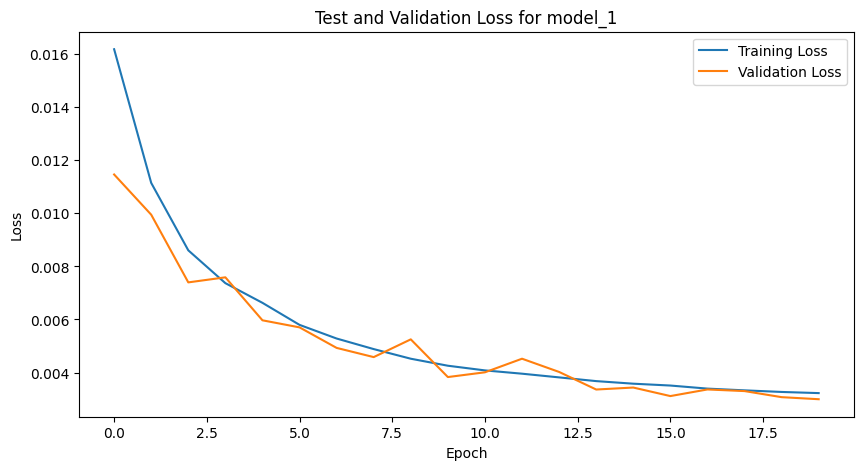

In [21]:
plot_train_val_loss(model_1_results, list(models.keys())[0])

## Model 2

Deeper autoencoder with dropout and normalization

In [22]:
# Define the autoencoder model
import torch.nn as nn

class DeepAutoencoder(torch.nn.Module):
    def __init__(self, input_dim):
        super(DeepAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
# Initialize the model, loss function and optimizer
model_2 = DeepAutoencoder(input_dim=train_data_scaled.shape[1])
loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)

# Move model to appropriate device
model_2.to(device)
models["model_2"]=model_2

In [24]:
model_2_results = train(model_name = list(models.keys())[1],
                        model=model_2,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer_2,
                        loss_fn=loss_fn_2,
                        epochs=EPOCHS,
                        device=device,
                        load_model=LOAD_MODEL,
                        save_model=SAVE_MODEL)

Model loaded from models\All_Purchases\model_2.pth


Image has been saved at Images\All_Purchases\model_2_Train_Val_Loss


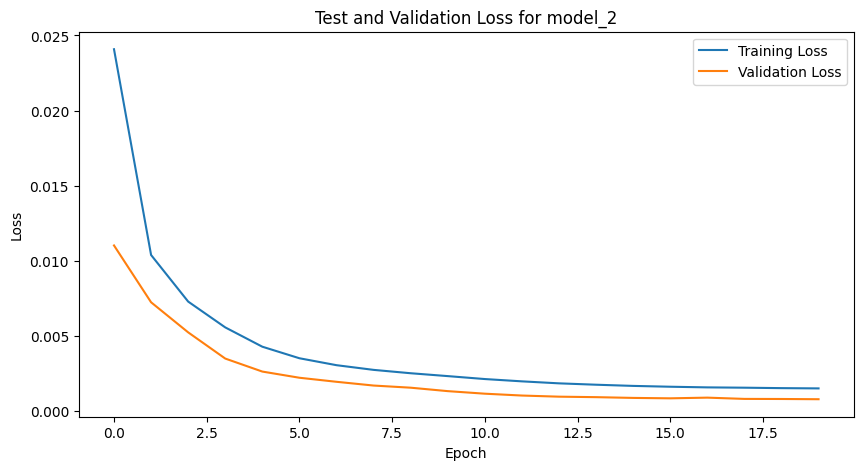

In [25]:
plot_train_val_loss(model_2_results, list(models.keys())[1])

## Model 3

Denoising Autoencoder

In [26]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, noise_factor=0.5):
        super(DenoisingAutoencoder, self).__init__()
        self.noise_factor = noise_factor
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, input_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        x_noisy = x + self.noise_factor * torch.randn_like(x)  # Add noise to the input
        x_noisy = torch.clamp(x_noisy, 0., 1.)  # Ensure the noisy input values are between 0 and 1.
        x_encoded = self.encoder(x_noisy)  # Encode the noisy input
        x_decoded = self.decoder(x_encoded)  # Decode the encoded representation
        return x_decoded

In [27]:
# Initialize the model, loss function and optimizer
model_3 = DenoisingAutoencoder(input_dim=train_data_scaled.shape[1])
loss_fn_3 = nn.MSELoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=LEARNING_RATE)

# Move model to appropriate device
model_3.to(device)
models["model_3"]=model_3

In [28]:
model_3_results = train(model_name = list(models.keys())[2],
                        model=model_3,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer_3,
                        loss_fn=loss_fn_3,
                        epochs=EPOCHS,
                        device=device,
                        load_model=LOAD_MODEL,
                        save_model=SAVE_MODEL)

Model loaded from models\All_Purchases\model_3.pth


Image has been saved at Images\All_Purchases\model_3_Train_Val_Loss


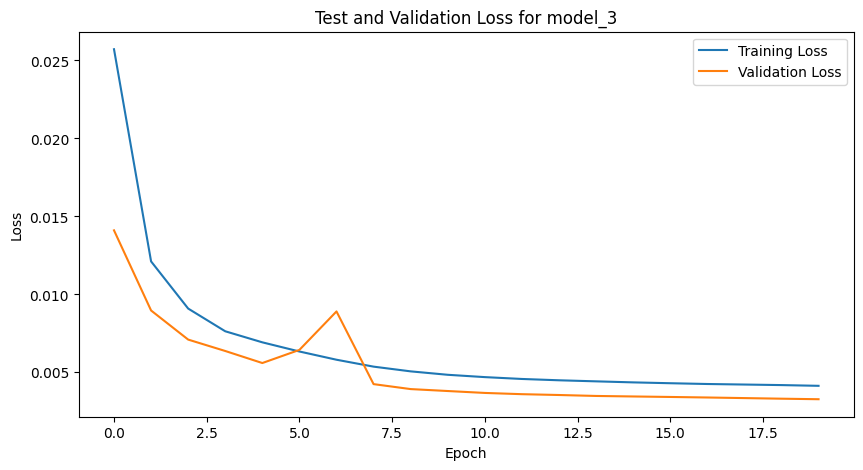

In [29]:
plot_train_val_loss(model_3_results, list(models.keys())[2])

## Model 4

Sparse Autoencoder

In [30]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(SparseAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        self.mean_activation = torch.mean(x, dim=0)  # Compute the mean activation
        x = self.decoder(x)
        return x

In [31]:
def sparse_loss_fn(model, X, X_pred, beta=1e-3, rho=0.05, epsilon=1e-7):
    # Reconstruction loss
    mse_loss = nn.MSELoss()(X_pred, X)

    # Ensure mean_activation is not exactly 0 or 1
    mean_activation = torch.clamp(model.mean_activation, min=epsilon, max=1-epsilon)

    # Sparsity loss
    sparsity_loss = torch.abs(torch.sum(rho * torch.log(rho / mean_activation) + (1 - rho) * torch.log((1 - rho) / (1 - mean_activation))))

    # Total loss
    total_loss = mse_loss + beta * sparsity_loss

    return total_loss

In [32]:
# Initialize the model, loss function and optimizer
model_4 = SparseAutoencoder(input_dim=train_data_scaled.shape[1])
loss_fn_4 = sparse_loss_fn
optimizer_4 = optim.Adam(model_4.parameters(), lr=LEARNING_RATE)

# Move model to appropriate device
model_4.to(device)
models["model_4"]=model_4

In [33]:
model_4_results = train(model_name = list(models.keys())[3],
                        model=model_4,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer_4,
                        loss_fn=loss_fn_4,
                        epochs=EPOCHS,
                        device=device,
                        sparse=True,
                        load_model=LOAD_MODEL,
                        save_model=SAVE_MODEL)

Model loaded from models\All_Purchases\model_4.pth


Image has been saved at Images\All_Purchases\model_4_Train_Val_Loss


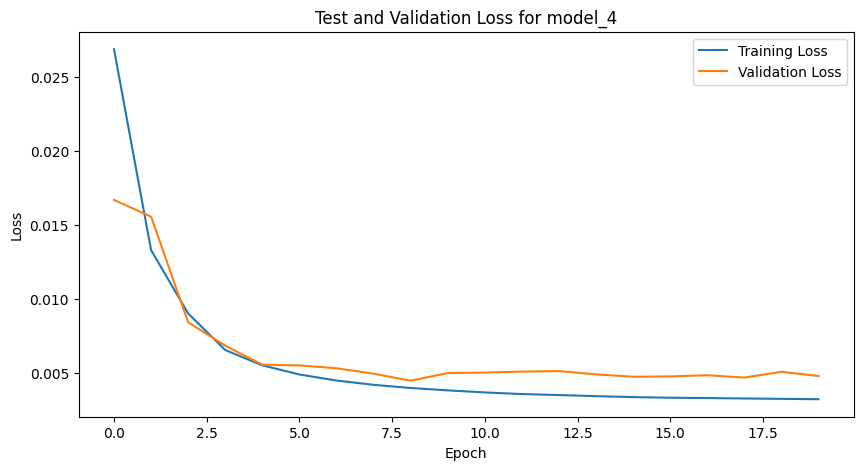

In [34]:
plot_train_val_loss(model_4_results, list(models.keys())[3])

## Comparison Graphs

In [35]:
# Create a dictionary of model results
model_dict = {
    'model_1': model_1_results,
    'model_2': model_2_results,
    'model_3': model_3_results,
    'model_4': model_4_results
}

final_results = {
    model_name: {
        key: value[-1] if isinstance(value, list) and len(value) > 1 else value
        for key, value in model.items()
    }
    for model_name, model in model_dict.items()
}

# Create DataFrame with correct orientation and add training time
results = pd.DataFrame(final_results).T

results

train_loss  val_loss   train_time
model_1    0.003226  0.002995   597.201953
model_2    0.001518  0.000798   896.574678
model_3    0.004138  0.003279   946.267649
model_4    0.003234  0.004800  1043.932900

Image has been saved at Images\All_Purchases\TrainLoss_ValLoss_TrainTime_Bar


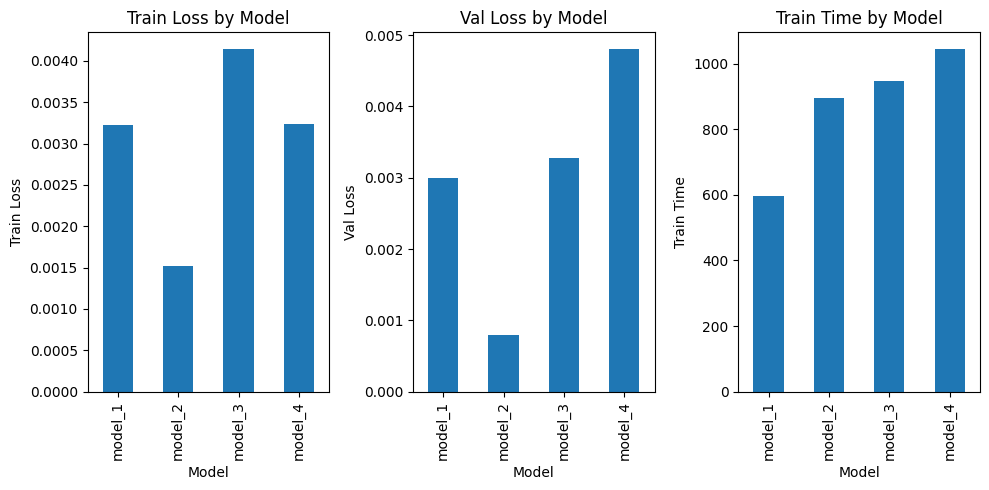

In [36]:
plt.figure(figsize=(10,5))

plt.subplot(1, 3, 1)
results['train_loss'].plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Train Loss')
plt.title('Train Loss by Model')

plt.subplot(1, 3, 2)
results['val_loss'].plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Val Loss')
plt.title('Val Loss by Model')

plt.subplot(1, 3, 3)
results['train_time'].plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Train Time')
plt.title('Train Time by Model')

plt.tight_layout()  # Adjusts spacing between subplots for better layout
file_name = "TrainLoss_ValLoss_TrainTime"

save_plot("TrainLoss_ValLoss_TrainTime_Bar", image_dir_path, plt)

plt.show()

Image has been saved at Images\All_Purchases\TrainLoss_ValLoss_Line


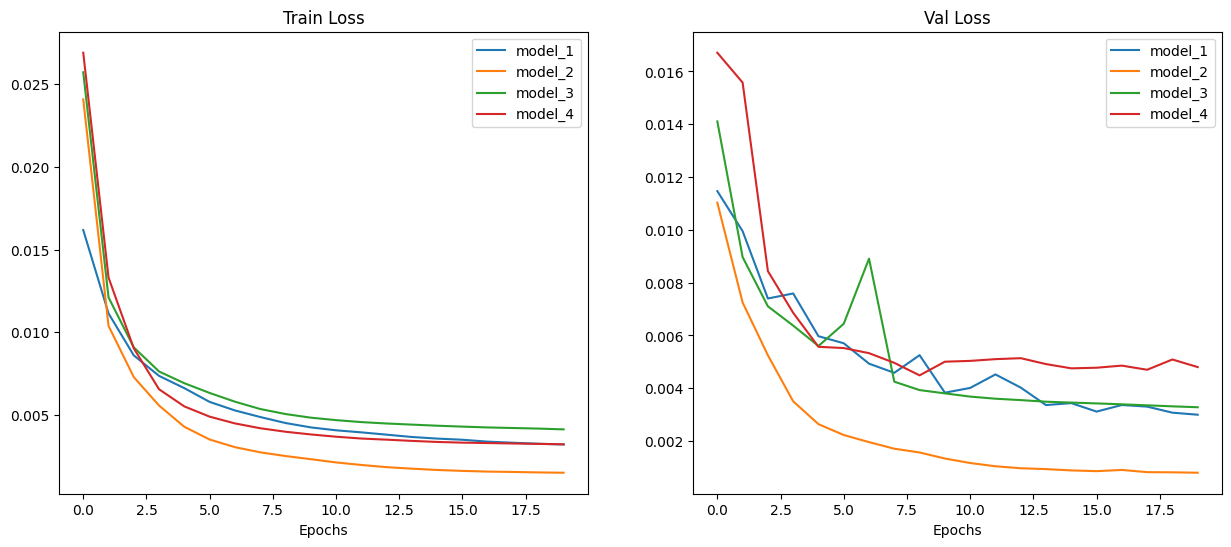

In [37]:
# Setup a plot
plt.figure(figsize=(15,6))

# Get number of epochs
epochs = range(len(model_1_results["train_loss"]))

# Plot train loss
plt.subplot(1, 2, 1)
for i in range(len(model_dict)):
    plt.plot(epochs, model_dict[list(model_dict)[i]]['train_loss'], label=list(model_dict)[i])
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot val loss
plt.subplot(1, 2, 2)
for i in range(len(model_dict)):
    plt.plot(epochs, model_dict[list(model_dict)[i]]['val_loss'], label=list(model_dict)[i])
plt.title("Val Loss")
plt.xlabel("Epochs")
plt.legend()

save_plot("TrainLoss_ValLoss_Line", image_dir_path, plt)

plt.show()

# Graphing in Latent Space

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
from torch import linalg as LA

def apply_pca_optimized(data, n_components=None, visualize=True, labels=None, image_dir_path=image_dir_path):
    """
    Apply Principal Component Analysis (PCA) on the given data and optionally visualize the results.
    The data will be reduced to 2 dimensions for visualization.

    :param data: Input data to apply PCA on.
    :param n_components: Number of principal components to consider for transformation. If None, use all components.
    :param visualize: Whether to visualize the results. Defaults to True.
    :return: Transformed data after applying PCA.
    """
    # Apply PCA using sklearn
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data)

    # Visualize the results if required
    if visualize:
        visualize_pca(transformed_data, labels, image_dir_path)

    # Print the total explained variance
    print("Total Explained Variance ({} components): {:.2%}".format(n_components if n_components else data.shape[1], np.sum(pca.explained_variance_ratio_)))

    return transformed_data

def visualize_pca(transformed_data, labels=None, image_dir_path=image_dir_path):
    """Visualize the PCA results in 2D space."""
    # Apply PCA for 2D visualization
    pca_2d = PCA(n_components=2)
    transformed_data_2d = pca_2d.fit_transform(transformed_data)

    plt.figure(figsize=(10,10))
    plt.scatter(transformed_data_2d[:, 0], transformed_data_2d[:, 1], c=labels, s=1, cmap='viridis')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("2D PCA Projection")
    
    if labels is not None:
        save_plot("PCA_Visualization_Labels", image_dir_path, plt)
    else:    
        save_plot("PCA_Visualization", image_dir_path, plt)
    
    plt.show()
    
def plot_cumulative_variance(data, max_components=15, image_dir_path=image_dir_path):
    """
    Plot cumulative explained variance against the number of components.
    """
    # Convert data to PyTorch tensor and move to the device
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)

    # Center the data
    mean_centered_data = data_tensor - data_tensor.mean(dim=0)

    # Compute the covariance matrix
    covariance_matrix = torch.mm(mean_centered_data.T, mean_centered_data) / (data_tensor.size(0) - 1)

    # Compute eigenvalues
    eigenvalues, _ = LA.eig(covariance_matrix)
    eigenvalues = torch.real(eigenvalues)

    # Sort the eigenvalues in descending order
    sorted_eigenvalues, _ = torch.sort(eigenvalues, descending=True)

    # Compute the cumulative explained variance
    cumulative_explained_variances = torch.cumsum(sorted_eigenvalues, dim=0) / torch.sum(sorted_eigenvalues)

    # Plotting
    plt.figure(figsize=(10,6))
    plt.plot(range(1, max_components+1), cumulative_explained_variances[:max_components].cpu().numpy(), marker='o')
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.ylim(0, 1)
    plt.grid(True)
    
    save_plot("Cumulative_Variance", image_dir_path, plt)
    
    plt.show()

def plot_clusters(data, max_clusters=10, image_dir_path=image_dir_path):
    """
    Display a line graph with points to visualize the sum of squared distances (SSD) for different cluster numbers.
    """
    # Compute the SSD for the range of clusters
    ssd = [KMeans(n_clusters=k, n_init=10).fit(data).inertia_ for k in range(1, max_clusters+1)]

    # Visualization
    k_values = range(1, max_clusters+1)
    plt.figure(figsize=(6, 6))
    plt.plot(k_values, ssd, '-')
    plt.scatter(k_values, ssd, color='b')
    plt.title('Sum of Squared Distances vs Number of Clusters')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.grid(True)
    
    save_plot("Cluster_Plot", image_dir_path, plt)
    
    plt.show()

## Finding top 3 anomalous columns

In [39]:
# Combine training and validation data
df_scaled = scaler.fit_transform(df)

# Convert data to PyTorch tensors
dataset = TensorDataset(torch.tensor(df_scaled, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
import torch

def calculate_reconstruction_and_top_3_values(model_name, model, dataloader, df_scaled, device):
    reconstructed_batches = []
    model.eval()
    with torch.inference_mode():
        for batch_data in tqdm(dataloader, desc=f'Processing {model_name}'):
            inputs = batch_data[0].to(device)
            reconstructed_batch = model(inputs)
            reconstructed_batches.append(reconstructed_batch)

    reconstructed = torch.cat(reconstructed_batches, dim=0).to(device)
    
    # Reconstruction error calculation
    reconstruction_error = ((reconstructed - torch.tensor(df_scaled, dtype=torch.float32).to(device)) ** 2).mean(dim=1).cpu().numpy()
    
    # Top 3 values calculation
    difference_percentage = 100 * (reconstructed - torch.tensor(df_scaled, dtype=torch.float32).to(device)) / (torch.tensor(df_scaled, dtype=torch.float32).to(device) + 1e-9)
    difference_df = pd.DataFrame(difference_percentage.cpu().numpy())
    
    # Ensure that difference_df is a tensor
    difference_tensor = torch.tensor(difference_df.values).to(device)

    # Compute the absolute value
    abs_difference_tensor = torch.abs(difference_tensor)

    # Determine the top 3 maximum absolute differences and their indices for each row
    top_3_max_diff_values, indices = torch.topk(abs_difference_tensor, 3, dim=1)

    # Convert the indices to column names
    top_3_column_names_from_df = [[df.columns[i] for i in row] for row in indices.cpu().numpy()]

    # Separate the values for each top 3 column
    top_3_values = top_3_max_diff_values.cpu().numpy()

    # Create a new DataFrame to store the top 3 max column names and values
    top_3_max_diff_df = pd.DataFrame({
        'Top_1_Column': [row[0] for row in top_3_column_names_from_df],
        'Top_1_Value': top_3_values[:, 0],
        'Top_2_Column': [row[1] for row in top_3_column_names_from_df],
        'Top_2_Value': top_3_values[:, 1],
        'Top_3_Column': [row[2] for row in top_3_column_names_from_df],
        'Top_3_Value': top_3_values[:, 2],
    })
        
    return reconstruction_error, top_3_max_diff_df

## PCA Analysis

Image has been saved at Images\All_Purchases\Cumulative_Variance


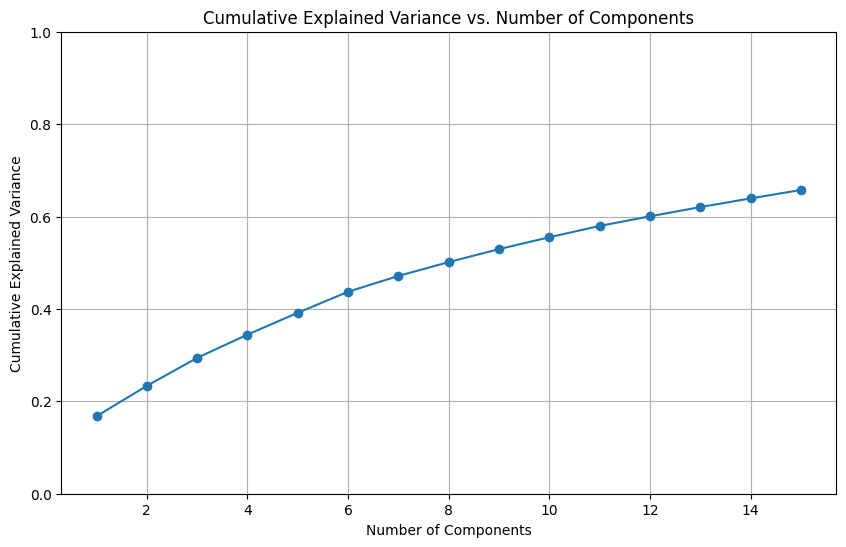

In [41]:
plot_cumulative_variance(df_scaled)

In [42]:
dim_input = int(input("Please enter the number of dimensions: "))

Please enter the number of dimensions: 9


Image has been saved at Images\All_Purchases\PCA_Visualization


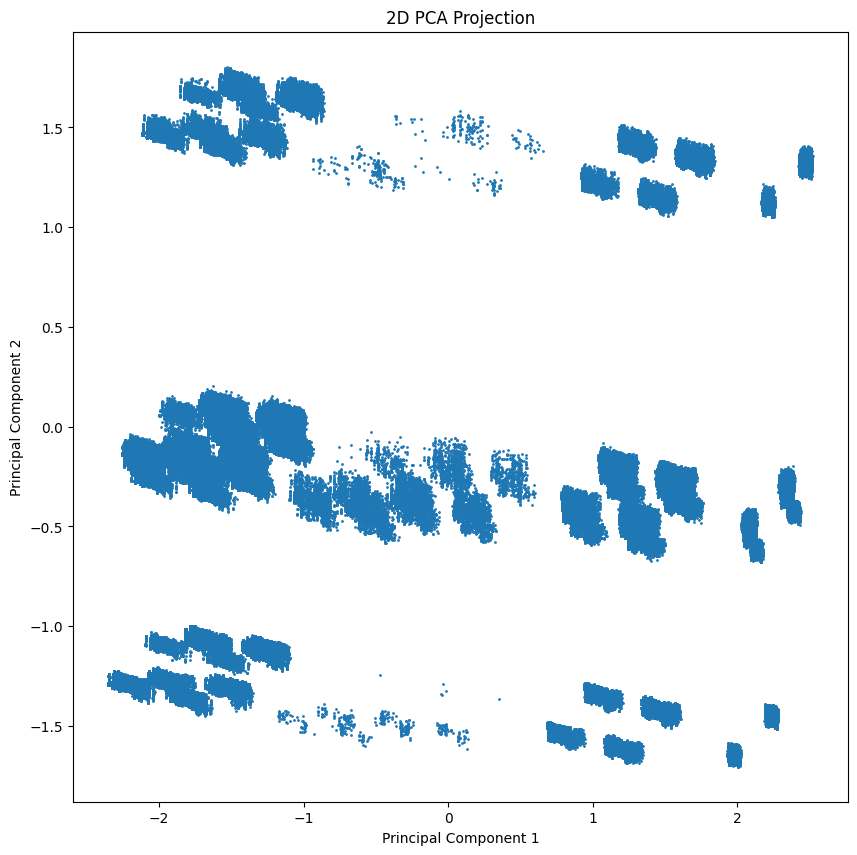

Total Explained Variance (9 components): 52.95%


In [43]:
# PCA Analysis
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transformed_data = apply_pca_optimized(df_scaled, n_components=dim_input)

Image has been saved at Images\All_Purchases\Cluster_Plot


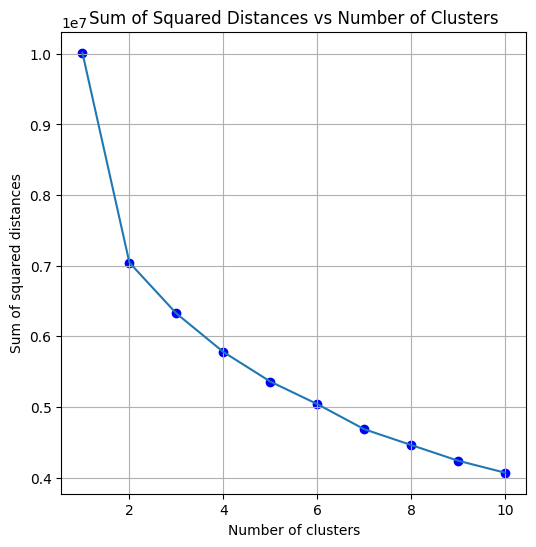

In [44]:
# Visualize Cluster SSD
plot_clusters(transformed_data)

In [45]:
cluster_input = int(input("Please enter the number of clusters: "))

Please enter the number of clusters: 4


In [46]:
kmeans = KMeans(n_clusters=cluster_input, n_init=10)
kmeans.fit(transformed_data)
labels = kmeans.labels_
df_labels = pd.DataFrame(labels, columns=['PCA_Labels'])

Image has been saved at Images\All_Purchases\PCA_Visualization_Labels


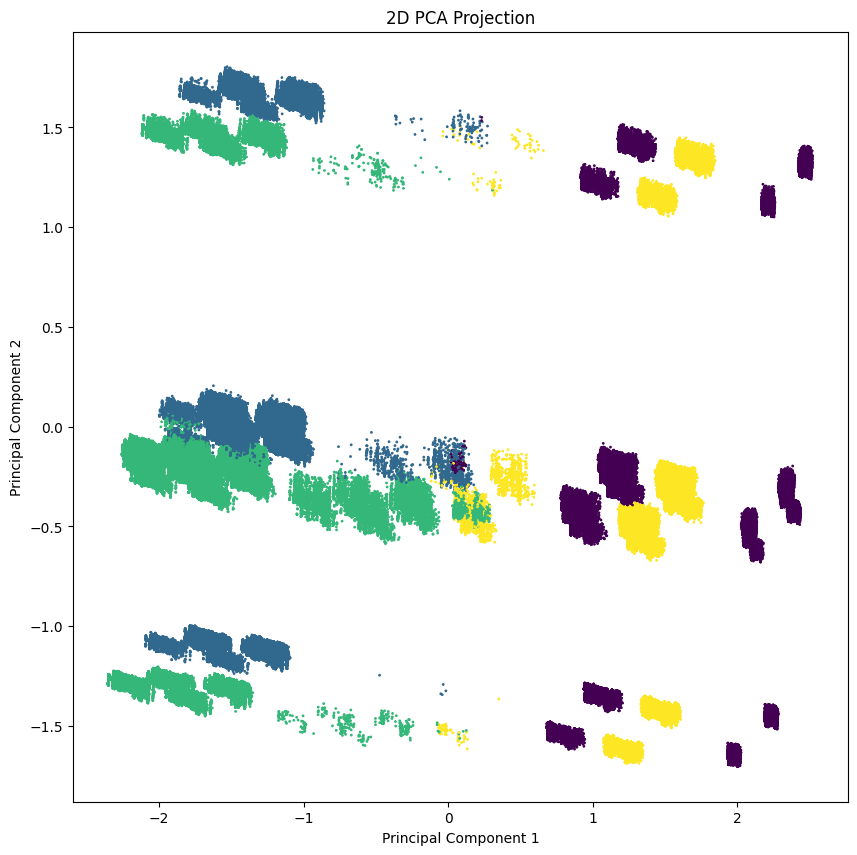

In [47]:
visualize_pca(transformed_data, labels=labels)

In [48]:
df_transformed_data = pd.DataFrame(transformed_data)
df_transformed_data['PCA_Labels'] = labels
sampled_data = df_transformed_data.sample(n=10000)

Image has been saved at Images\All_Purchases\PCA_Pairplot


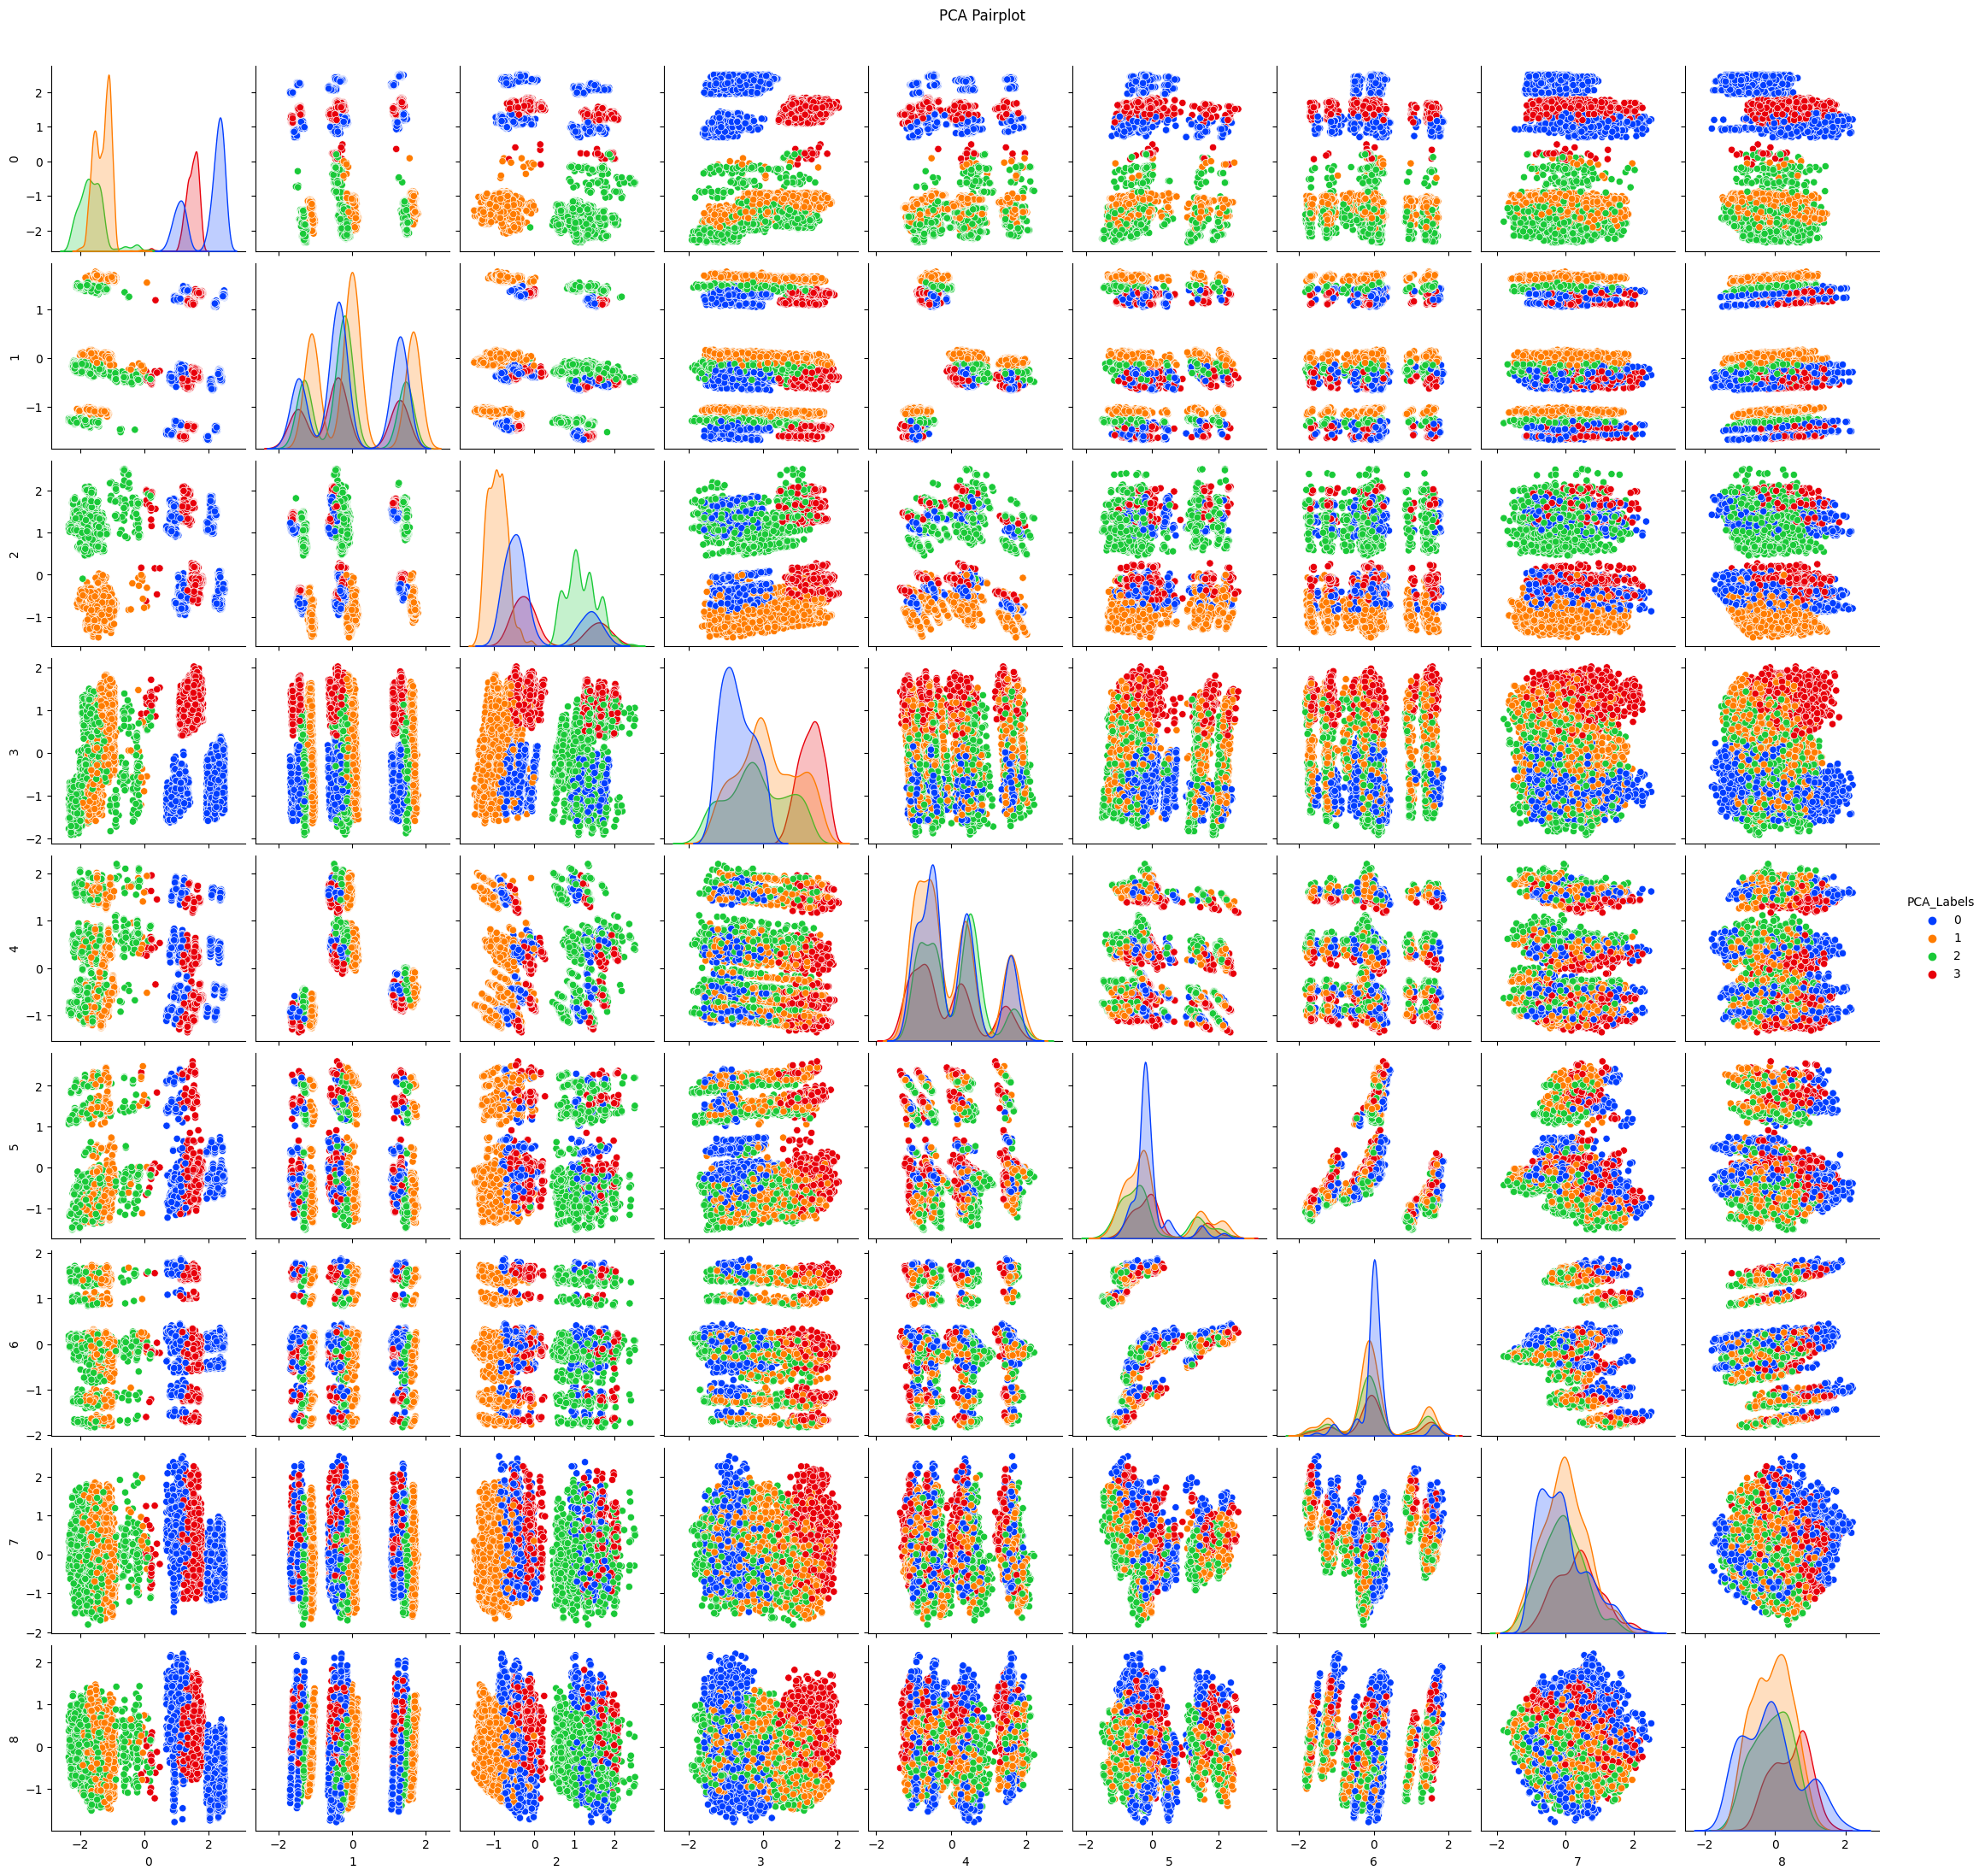

In [49]:
import seaborn as sns

# Create the pairplot
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot = sns.pairplot(sampled_data, hue='PCA_Labels', palette="bright")

    # Adjusting space at the top for the title
    plt.subplots_adjust(top=0.95)  
    plt.suptitle("PCA Pairplot")

    # Call the save_plot function to save the image, with the correct file extension
    save_plot("PCA_Pairplot", image_dir_path, plot.fig)

## Finding anomalies

In [50]:
from tqdm.notebook import tqdm
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def detect_anomalies(reconstruction_error, threshold):
    anomaly_threshold = np.percentile(reconstruction_error, threshold)
    return reconstruction_error > anomaly_threshold

def create_dataframe(reconstruction_error, df_orig, df_top_3, df_labels):
    scores_df = pd.DataFrame(reconstruction_error, columns=['anomaly_score'])
    df_score = pd.concat([scores_df, df_orig, df_top_3, df_labels], axis=1)
    return df_score

def save_anomalies(all_anomalies, model_name, filename, result_dir_path=None):
    if result_dir_path is None:
        raise ValueError("result_dir_path must be provided.")
    dir_path = os.path.join(result_dir_path, model_name)
    os.makedirs(dir_path, exist_ok=True)
    all_anomalies.to_csv(os.path.join(dir_path, filename), index=False)

def filter_recent_anomalies(all_anomalies):
    cutoff_date = datetime.now() - timedelta(days=30)
    all_anomalies['sls_d'] = pd.to_datetime(all_anomalies['sls_d'])
    df_filtered = all_anomalies[all_anomalies['sls_d'] >= cutoff_date]
    return df_filtered.sort_values(by=['anomaly_score', 'sls_d', 'start_tm'], ascending=[False, False, True])

def detect_and_save_anomalies(model_name, model, dataloader, df_top_3, labels, df_orig, threshold=99.9, result_dir_path=None, reconstruction_error=None):
    if reconstruction_error is None:
        raise ValueError("reconstruction_error must be provided.")
    if result_dir_path is None:
        raise ValueError("result_dir_path must be provided.")
    print(f"{model_name} has estimated outputs")
    anomalies = detect_anomalies(reconstruction_error, threshold)
    print(f"{model_name} reconstruction error calculated")
    df_score = create_dataframe(reconstruction_error, df_orig, df_top_3, pd.DataFrame(labels, columns=['PCA_Labels'])) # Added labels as a DataFrame
    all_anomalies = df_score[df_score.index.isin(df_orig[anomalies].index)].sort_values(by='anomaly_score', ascending=False)
    print(f"{model_name} anomaly dataframe created")
    save_anomalies(all_anomalies, model_name, "All_Anomalies.csv", result_dir_path)
    print(f"{model_name} anomaly csv saved")
    df_filtered = filter_recent_anomalies(all_anomalies)
    # No index resetting here
    save_anomalies(df_filtered, model_name, "Recent_Anomalies.csv", result_dir_path)
    print(f"{model_name} recent anomaly csv saved\n")

### Export to CSV

In [51]:
for key, value in models.items():
    reconstruction_error, top_3_max_diff_df = calculate_reconstruction_and_top_3_values(key, value, dataloader, df_scaled, device)
    detect_and_save_anomalies(key, value, dataloader, top_3_max_diff_df, labels, df_orig, 99.9, result_dir_path=result_dir_path, reconstruction_error=reconstruction_error)

Processing model_1:   0%|          | 0/9072 [00:00<?, ?it/s]

model_1 has estimated outputs
model_1 reconstruction error calculated
model_1 anomaly dataframe created
model_1 anomaly csv saved
model_1 recent anomaly csv saved



Processing model_2:   0%|          | 0/9072 [00:00<?, ?it/s]

model_2 has estimated outputs
model_2 reconstruction error calculated
model_2 anomaly dataframe created
model_2 anomaly csv saved
model_2 recent anomaly csv saved



Processing model_3:   0%|          | 0/9072 [00:00<?, ?it/s]

model_3 has estimated outputs
model_3 reconstruction error calculated
model_3 anomaly dataframe created
model_3 anomaly csv saved
model_3 recent anomaly csv saved



Processing model_4:   0%|          | 0/9072 [00:00<?, ?it/s]

model_4 has estimated outputs
model_4 reconstruction error calculated
model_4 anomaly dataframe created
model_4 anomaly csv saved
model_4 recent anomaly csv saved

